In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
import random

In [2]:
num_nodes = 5
num_node_features = 10
x = torch.randn(num_nodes, num_node_features)
print(x)

tensor([[ 1.2237, -0.0609,  0.0571,  0.8944, -0.3309,  0.2260,  1.3151, -0.3613,
          0.4258,  1.1920],
        [ 1.0798,  0.4569, -2.1319, -0.7445,  0.4033,  0.7925, -0.1368, -0.9923,
          0.7907, -0.5027],
        [-0.4576, -1.1346, -0.7803,  0.1845,  0.9679, -0.5097,  0.3508, -0.5816,
         -0.3173, -0.7536],
        [-0.7959,  0.8983,  0.6929, -0.1227, -3.9789, -0.5689, -0.6494, -0.3644,
         -0.3733,  1.5416],
        [ 0.0740,  1.5508, -2.4168,  0.5751,  0.8419,  1.2467, -0.9294, -0.4670,
         -0.8767, -0.2428]])


In [3]:
pos = torch.randn(num_nodes, 2)
print(pos)

tensor([[ 2.6097, -0.4044],
        [ 1.4294,  1.0204],
        [ 1.0518,  1.3421],
        [-1.2162, -0.8068],
        [-0.2738,  0.5646]])


In [4]:
edge_index = knn_graph(pos, k=4, loop=False)

In [11]:
y = x.sum(dim=1).mean().unsqueeze(0)

data = Data(x=x, edge_index=edge_index, pos=pos, y=y)

In [12]:
print(data.pos)

tensor([[ 2.6097, -0.4044],
        [ 1.4294,  1.0204],
        [ 1.0518,  1.3421],
        [-1.2162, -0.8068],
        [-0.2738,  0.5646]])


### visualizing geometric data object as a networkx graph

In [13]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [9]:
G = to_networkx(
    data,
    to_undirected=True,
    node_attrs=['x'],
    edge_attrs=None
)

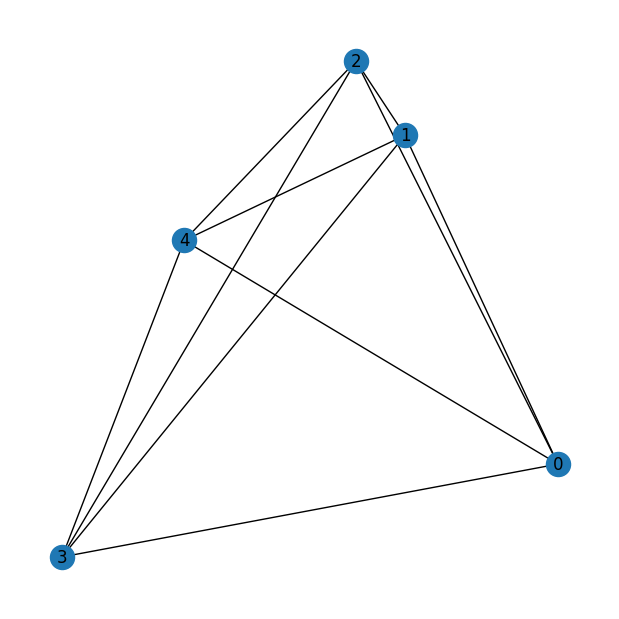

In [14]:
# the position helps to visualize the true graph. If pos is not passed to nx.draw, we lose information on 
# the position of the nodes (see the cell below this)
pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}

plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos,
    node_size=300,
    with_labels=True
)
plt.show()

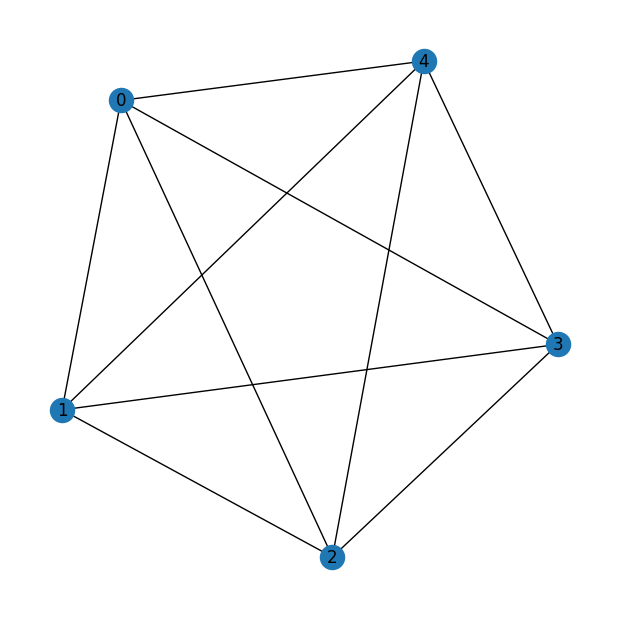

In [16]:
# this will give a neat graph 
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    node_size=300,
    with_labels=True
)
plt.show()